> 使用行业内的排序，进行因子测试；与回归版本，以及原始因子值版本进行比较。本部分参考自《QEPM》 p.p 117

# 参数设定
--------------

In [147]:
%matplotlib inline
import pandas as pd
import numpy as np
from PyFin.api import *
from alphamind.api import *

factor = 'ROE'
universe = Universe('custom', ['zz800'])
start_date = '2010-01-01'
end_date = '2018-04-26'
freq = '20b'
category = 'sw_adj'
level = 1
horizon = map_freq(freq)

engine = SqlEngine()

ref_dates = makeSchedule(start_date, end_date, freq, 'china.sse')
sample_date = '2018-01-04'
sample_codes = engine.fetch_codes(sample_date, universe)

sample_industry = engine.fetch_industry(sample_date, sample_codes, category=category, level=level)

In [148]:
sample_industry.head()

,code,industry_code,industry
0,1,103032101,银行
1,2,1030320,房地产
2,6,1030320,房地产
3,8,1030309,机械设备
4,9,1030328,综合


# 样例因子
--------------------

我们下面分三种方法，分别考查这几种方法在避免行业集中上面的效果：

* 使用原始因子的排序；
* 使用原始因子在行业内的排序；
* 使用原始因子在行业哑变量上回归后得到的残差排序。

## 1. 原始因子排序
--------------------

In [149]:
factor1 = {'f1': CSQuantiles(factor)}
sample_factor1 = engine.fetch_factor(sample_date, factor1, sample_codes)
sample_factor1 = pd.merge(sample_factor1, sample_industry[['code', 'industry']], on='code')

In [150]:
sample_factor1.sort_values('f1', ascending=False).head(15)

,code,isOpen,ROE,f1,industry
498,600338,True,0.7519,0.998748,有色金属
160,2027,True,0.6672,0.997497,传媒
43,513,True,0.6227,0.996245,医药生物
489,600309,False,0.5198,0.994994,化工
509,600380,True,0.4824,0.993742,医药生物
449,600161,True,0.4538,0.992491,医药生物
334,2841,True,0.4463,0.991239,电子
361,300136,True,0.4368,0.989987,电子
795,603868,True,0.3969,0.988736,家用电器
771,603160,True,0.3923,0.987484,电子


对于原始因子，如果我们不做任何行业上面的处理，发现我们选定的alpha因子`CFO2EV`较大的股票集中于银行和大金融板块。

## 2. 行业内排序因子
----------------------

这里我们使用调整后的申万行业分类作为行业标签：

In [151]:
factor2 = {'f2': CSQuantiles(factor, groups='sw1_adj')}
sample_factor2 = engine.fetch_factor(sample_date, factor2, sample_codes)
sample_factor2 = pd.merge(sample_factor2, sample_industry[['code', 'industry']], on='code')
sample_factor2.sort_values('f2', ascending=False).head(15)

,code,isOpen,ROE,sw1_adj,f2,industry
544,600519,True,0.3364,30,1.0,食品饮料
352,300072,True,0.3581,5,1.0,公用事业
324,2714,True,0.3619,6,1.0,农林牧渔
419,600066,True,0.2849,18,1.0,汽车
334,2841,True,0.4463,19,1.0,电子
793,603833,True,0.3067,25,1.0,轻工制造
345,300033,True,0.3580,23,1.0,计算机
679,601012,True,0.2596,20,1.0,电气设备
702,601225,True,0.3131,27,1.0,采掘
514,600393,True,0.2697,15,1.0,房地产


使用行业内的排序，则行业分布会比较平均。

## 3. 使用回归将因子行业中性
--------------------------------

还有一种思路，使用线性回归，以行业为哑变量，使用回归后的残差作为因子的替代值，做到行业中性：

In [152]:
factor3 = {'f3': factor}
sample_factor3 = engine.fetch_factor(sample_date, factor3, sample_codes)
risk_cov, risk_exp = engine.fetch_risk_model(sample_date, sample_codes)
sample_factor3 = pd.merge(sample_factor3, sample_industry[['code', 'industry']], on='code')
sample_factor3 = pd.merge(sample_factor3, risk_exp, on='code')

In [153]:
raw_factors = sample_factor3['f3'].values
industry_exp = sample_factor3[industry_styles + ['COUNTRY']].values.astype(float)
processed_values = factor_processing(raw_factors, pre_process=[], risk_factors=industry_exp, post_process=[percentile])
sample_factor3['f3'] = processed_values

In [154]:
sample_factor3 = sample_factor3[['code', 'isOpen', 'f3', 'industry']]
sample_factor3.sort_values('f3', ascending=False).head(15)

,code,isOpen,f3,industry
799,603993,True,1.000000,有色金属
262,2416,True,0.998748,商业贸易
272,2444,True,0.997497,机械设备
271,2440,True,0.996245,化工
270,2439,True,0.994994,计算机
269,2437,True,0.993742,医药生物
268,2434,True,0.992491,汽车
267,2431,True,0.991239,建筑装饰
266,2428,True,0.989987,有色金属
265,2426,True,0.988736,机械设备


我们发现这种方法的效果并不是很好。调整的幅度并不是很大，同时仍然存在着集中于大金融板块的问题。

# 回测结果
------------------

我们使用简单等权重做多前20%支股票，做空后20%的方法，考察三种方法的效果：

In [155]:
factors = {
    'f1': CSQuantiles(factor),
    'f2': CSQuantiles(factor, groups='sw1_adj'),
    'f3': LAST(factor)
}

In [156]:
df_ret = pd.DataFrame(columns=['f1', 'f2', 'f3'])
df_ic = pd.DataFrame(columns=['f1', 'f2', 'f3'])

for date in ref_dates:
    ref_date = date.strftime('%Y-%m-%d')
    codes = engine.fetch_codes(ref_date, universe)

    total_factor = engine.fetch_factor(ref_date, factors, codes)
    risk_cov, risk_exp = engine.fetch_risk_model(ref_date, codes)
    industry = engine.fetch_industry(ref_date, codes, category=category, level=level)
    rets = engine.fetch_dx_return(ref_date, codes, horizon=horizon, offset=1)
    total_factor = pd.merge(total_factor, industry[['code', 'industry']], on='code')
    total_factor = pd.merge(total_factor, risk_exp, on='code')
    total_factor = pd.merge(total_factor, rets, on='code').dropna()

    raw_factors = total_factor['f3'].values
    industry_exp = total_factor[industry_styles + ['COUNTRY']].values.astype(float)
    processed_values = factor_processing(raw_factors, pre_process=[], risk_factors=industry_exp, post_process=[percentile])
    total_factor['f3'] = processed_values

    total_factor[['f1_d', 'f2_d', 'f3_d']] = (total_factor[['f1', 'f2', 'f3']] >= 0.8) * 1.
    total_factor.loc[total_factor['f1'] <= 0.2, 'f1_d'] = -1.
    total_factor.loc[total_factor['f2'] <= 0.2, 'f2_d'] = -1.
    total_factor.loc[total_factor['f3'] <= 0.2, 'f3_d'] = -1.
    total_factor[['f1_d', 'f2_d', 'f3_d']] /= np.abs(total_factor[['f1_d', 'f2_d', 'f3_d']]).sum(axis=0)

    ret_values = total_factor.dx.values @ total_factor[['f1_d', 'f2_d', 'f3_d']].values
    df_ret.loc[date] = ret_values
    
    ic_values = total_factor[['dx', 'f1', 'f2', 'f3']].corr().values[0, 1:]
    df_ic.loc[date] = ic_values
    print(f"{date} is finished")

2010-01-04 00:00:00 is finished
2010-02-01 00:00:00 is finished
2010-03-08 00:00:00 is finished
2010-04-06 00:00:00 is finished
2010-05-05 00:00:00 is finished
2010-06-02 00:00:00 is finished
2010-07-05 00:00:00 is finished
2010-08-02 00:00:00 is finished
2010-08-30 00:00:00 is finished
2010-09-30 00:00:00 is finished
2010-11-04 00:00:00 is finished
2010-12-02 00:00:00 is finished
2010-12-30 00:00:00 is finished
2011-01-28 00:00:00 is finished
2011-03-04 00:00:00 is finished
2011-04-01 00:00:00 is finished
2011-05-04 00:00:00 is finished
2011-06-01 00:00:00 is finished
2011-06-30 00:00:00 is finished
2011-07-28 00:00:00 is finished
2011-08-25 00:00:00 is finished
2011-09-23 00:00:00 is finished
2011-10-28 00:00:00 is finished
2011-11-25 00:00:00 is finished
2011-12-23 00:00:00 is finished
2012-01-31 00:00:00 is finished
2012-02-28 00:00:00 is finished
2012-03-27 00:00:00 is finished
2012-04-27 00:00:00 is finished
2012-05-29 00:00:00 is finished
2012-06-27 00:00:00 is finished
2012-07-

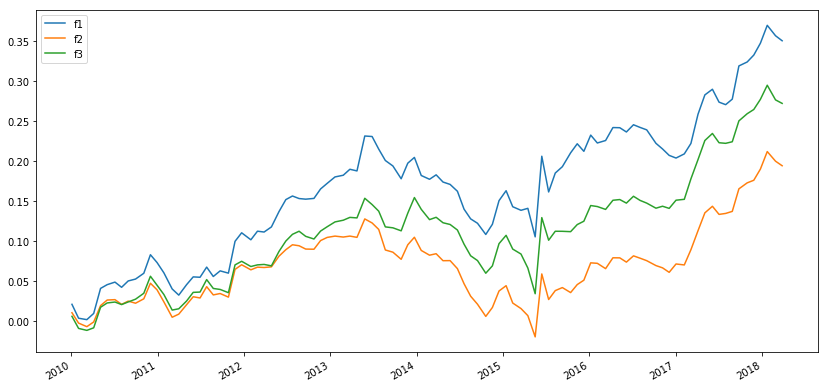

In [157]:
df_ret.cumsum().plot(figsize=(14, 7))

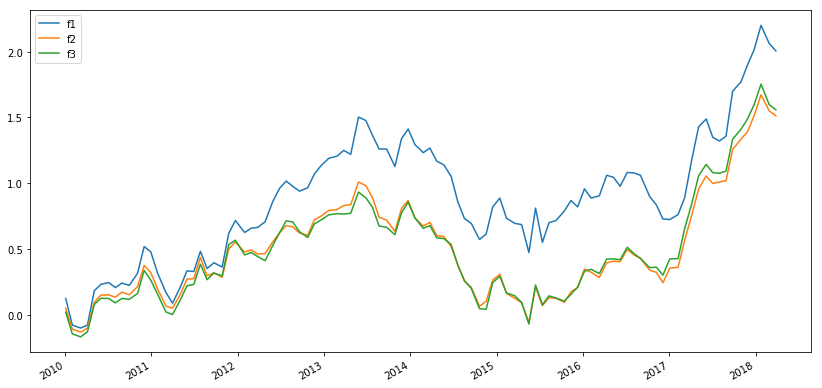

In [158]:
df_ic.cumsum().plot(figsize=(14, 7))